<h1><center> Predictive statistics on the I-SPY1 Clinical Trial</center></h1>

### 0. Load modules and clean data

In [1]:
# import custom modules wrote by julio
import pandas as pd
import numpy as np
RANDOM_STATE = 42; # for reproducibility
import matplotlib.pyplot as plt
%matplotlib inline


from ispy1 import predictive_statistics

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, linear_model 
from imblearn import over_sampling 
from sklearn.calibration import CalibratedClassifierCV

# reload modules without restartign the kernel (makes development easier)
import importlib
importlib.reload(predictive_statistics);

df = pd.read_csv('./data/I-SPY_1_clean_data.csv')
df.head(2)

,SUBJECTID,age,White,ER+,PR+,HR+,Bilateral,Right_Breast,MRI_LD_Baseline,MRI_LD_1_3dAC,MRI_LD_Int_Reg,MRI_LD_PreSurg,Alive,Survival_length,RFS,RFS_code,PCR,RCB
0,1001,38.73,Yes,Yes,No,Yes,No,No,88.0,78.0,30.0,14.0,No,1264,751,1,No,2.0
1,1002,37.79,Yes,Yes,Yes,Yes,No,Yes,29.0,26.0,66.0,16.0,No,1155,1043,1,No,3.0


In [28]:
def binary_classifier_metrics(classifier, Xtrain, Ytrain, Xtest, Ytest):
    # metrics
    predicted_class = classifier.predict(Xtest)
    
    kappa = metrics.cohen_kappa_score(Ytest,predicted_class)
    np.round(kappa,3)
    
    auc = metrics.roc_auc_score(Ytest,predicted_class)
    auc = np.round(auc,3)
    

    # ROC curve
    probability = classifier.predict_proba(Xtest)
    fpr, tpr, _  = metrics.roc_curve(Ytest, probability[:,1])        
    
    # report 
    print(metrics.classification_report(Ytest,predicted_class))
    print('The estimated Cohen kappa is ' + str(kappa))
    print('The estimated AUC is ' + str(auc))
    print('=='*30)
    print('\n'*2)

    return auc, kappa, fpr, tpr


def split_data(Xdata,Ydata, oversample, K_neighbors):
    if oversample == False:
        X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata,
                                                            train_size = 0.70,
                                                            random_state=RANDOM_STATE)
    
    elif oversample == True:
        print('Data was oversampled using the ADASYN method')
        smote = over_sampling.ADASYN(random_state = RANDOM_STATE, n_neighbors = K_neighbors)
        # split
        X_train, X_test, y_train, y_test = train_test_split(Xdata, Ydata,train_size = 0.70,
                                                            random_state=RANDOM_STATE)
        # oversample the train sets
        #X_train, y_train = smote.fit_sample(X_train,y_train)
        
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                            train_size = 0.70,
                                                            random_state=RANDOM_STATE, stratify = y_resampled)

    return X_train, X_test, y_train, y_test
    

# perform Logistic Regression without correcting for unbalance
def Logistic_Regression(Xdata, Ydata, oversample = False, K_neighbors = 4):
    
    # split data
    X_train, X_test, y_train, y_test = split_data(Xdata,Ydata, oversample, K_neighbors)

    # train and tune parameters using GridSearchCV
    pars= dict(   C = np.arange(.01,100,.1) )
    
    grid =  GridSearchCV(  linear_model.LogisticRegression(), param_grid = pars, 
                           scoring = metrics.make_scorer(metrics.cohen_kappa_score), 
                           cv= 5, verbose = 0, n_jobs = -1)
        
    # fit
    grid.fit(X_train,y_train)
    
    # metrics
    auc, kappa, fpr, tpr = binary_classifier_metrics(grid, X_train, y_train, X_test, y_test)
    
    # output
    return auc, kappa, fpr, tpr 

# Random Forest Regressor
from sklearn.ensemble import RandomForestClassifier as RFC

def RandomForest_Classifier(Xdata, Ydata, oversample = False, K_neighbors = 4, calibrate_prob = True):
    
    # split data
    X_train, X_test, y_train, y_test = split_data(Xdata,Ydata, oversample, K_neighbors)
        
    # define parameter grid search
    pars = dict(    n_estimators = np.arange(1,10,1), 
                    max_features = np.arange(1, X.shape[1], 1),
                    max_depth = [None, 1, 2, 3, 4, 5])
    
    # perform grid search
    grid=  GridSearchCV(RFC( random_state = RANDOM_STATE),param_grid = pars, 
                           scoring = metrics.make_scorer(metrics.cohen_kappa_score), 
                           cv= 3, verbose = 0, n_jobs = -1)
    
    # fit
    grid.fit(X_train,y_train)
    
    # get best classifier and calibrate it
    clv = CalibratedClassifierCV(base_estimator = grid.best_estimator_ , method='sigmoid', cv=3)
    
    
    # metrics
    auc, kappa, fpr, tpr = binary_classifier_metrics(grid, X_train, y_train, X_test, y_test)
    
    # output
    return auc, kappa, fpr, tpr, grid.best_estimator_ 

def plot_forest_feature_importances_(forest, features_legend, title = ''):
    importances = forest.feature_importances_;
    importances = importances / np.max(importances)
    sorted_index = np.argsort(importances)
  
    x = range(len(importances));

    plt.figure()
    plt.barh(x, importances[sorted_index],color="b", align="center")

    plt.yticks(sorted_index, features_legend);
    plt.title(title);
    plt.xlabel('RELATIVE IMPORTANCE');
    plt.ylabel('PREDICTOR');


def plot_compare_roc(fpr1_, tpr1_,fpr2_, tpr2_, auc1, auc2, title =''):
    plt.figure()
    plt.plot(fpr1_, tpr1_, fpr2_, tpr2_);
    plt.legend(['Unbalanced | AUC = ' + str(auc1),'Oversampled | AUC = ' + str(auc2)]);
    plt.xlabel('False-positive rate');
    plt.ylabel('True-positive rate');
    plt.title(title);

<h1><center> Prediction of categorical outcomes</center></h1>

## 1.0 Pathological Complete Response (PCR)

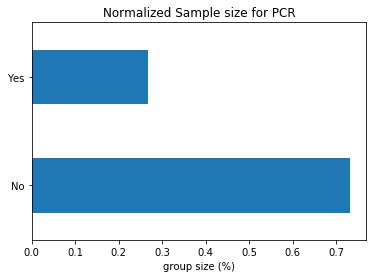

In [29]:
# allocate continous predictors
cont_predictors = ['age','MRI_LD_Baseline', 'MRI_LD_1_3dAC', 'MRI_LD_Int_Reg', 'MRI_LD_PreSurg']
X_cont = df[cont_predictors].values

# allocate clinical predictors
cat_predictors = ['White', 'ER+', 'PR+', 'HR+'];
X_cat = pd.pandas.get_dummies(df[cat_predictors], drop_first=True).values

# allocate a single predictors matrix X
X = np.concatenate( (X_cont, X_cat), axis=1)

# allocate  outcome 
outcome = 'PCR'
y = predictive_statistics.labels_to_numbers(df, outcome);

# check how unbalanced the data are
df[outcome].value_counts(normalize = True).plot.barh();
plt.title('Normalized Sample size for PCR')
plt.xlabel('group size (%)');
plt.savefig('Sample_Size_PCR.png')

## 1.0 Survival (`PCR`) 

- ### logistic Regression

In [31]:
# standard
auc1, kappa1, fpr1, tpr1 = Logistic_Regression(X, y)


# unbalanced learning
auc2, kappa2, fpr2, tpr2 = Logistic_Regression(X, y, oversample=True, K_neighbors = 4)

title ='Effect of oversampling on Logistic Regression for PCR'
plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, title = title)

             precision    recall  f1-score   support

          0       0.78      0.90      0.83        39
          1       0.33      0.17      0.22        12

avg / total       0.67      0.73      0.69        51

The estimated Cohen kappa is 0.077519379845
The estimated AUC is 0.532



Data was oversampled using the ADASYN method


NameError: name 'X_resampled' is not defined

- ### random forests

             precision    recall  f1-score   support

          0       0.80      0.92      0.86        39
          1       0.50      0.25      0.33        12

avg / total       0.73      0.76      0.73        51

The estimated Cohen kappa is 0.209302325581
The estimated AUC is 0.587



Data was oversampled using the SMOTE method
             precision    recall  f1-score   support

          0       0.78      0.72      0.75        39
          1       0.27      0.33      0.30        12

avg / total       0.66      0.63      0.64        51

The estimated Cohen kappa is 0.047197640118
The estimated AUC is 0.526





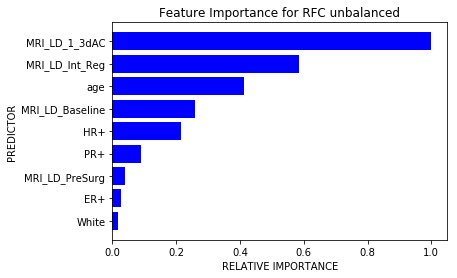

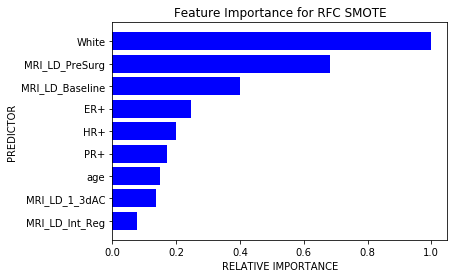

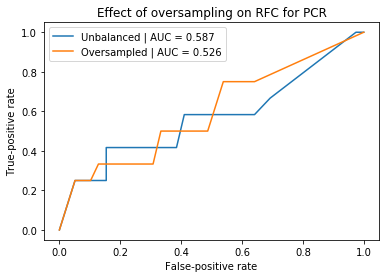

In [5]:
# standard
auc1, kappa1, fpr1, tpr1, forest = RandomForest_Classifier(X, y)
t ='Feature Importance for RFC unbalanced'
plot_forest_feature_importances_(forest, cont_predictors + cat_predictors, title = t)

# unbalanced learning
auc2, kappa2, fpr2, tpr2, Forest = RandomForest_Classifier(X, y, oversample=True, K_neighbors = 4)
t ='Feature Importance for RFC SMOTE'
plot_forest_feature_importances_(Forest, cont_predictors + cat_predictors, title = t)

# compare
title ='Effect of oversampling on RFC for PCR'
plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, title = title)

## 2.0 Survival (`Alive`) using Logistic Regression

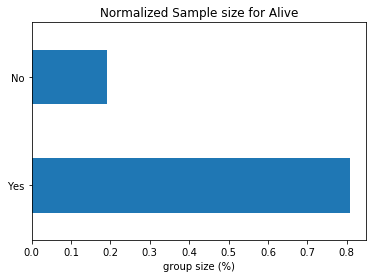

In [25]:
# allocate  outcome 
outcome = 'Alive'
y = predictive_statistics.labels_to_numbers(df, outcome);

# check how unbalanced the data are
df[outcome].value_counts(normalize = True).plot.barh();
plt.title('Normalized Sample size for Alive')
plt.xlabel('group size (%)');
plt.savefig('Sample_Size_Alive.png')

- ### Logistic Regression

             precision    recall  f1-score   support

          0       0.67      0.33      0.44        18
          1       0.84      0.95      0.89        66

avg / total       0.80      0.82      0.80        84

The estimated Cohen kappa is 0.351851851852
The estimated AUC is 0.644



Data was oversampled using the ADASYN method
             precision    recall  f1-score   support

          0       0.36      0.45      0.40        11
          1       0.84      0.78      0.81        40

avg / total       0.73      0.71      0.72        51

The estimated Cohen kappa is 0.208893485005
The estimated AUC is 0.615





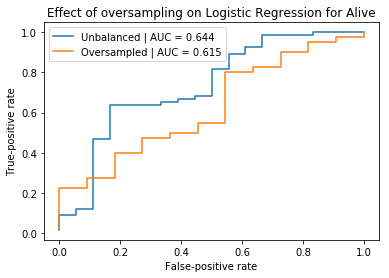

In [27]:
# standard
auc1, kappa1, fpr1, tpr1 = Logistic_Regression(X, y)

# unbalanced learning
auc2, kappa2, fpr2, tpr2 = Logistic_Regression(X, y, oversample=True, K_neighbors = 3)

title ='Effect of oversampling on Logistic Regression for Alive'
plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, title = title)

- ### random forests

             precision    recall  f1-score   support

          0       0.38      0.27      0.32        11
          1       0.81      0.88      0.84        40

avg / total       0.72      0.75      0.73        51

The estimated Cohen kappa is 0.16393442623
The estimated AUC is 0.574



Data was oversampled using the SMOTE method
             precision    recall  f1-score   support

          0       0.40      0.36      0.38        11
          1       0.83      0.85      0.84        40

avg / total       0.74      0.75      0.74        51

The estimated Cohen kappa is 0.220916568743
The estimated AUC is 0.607





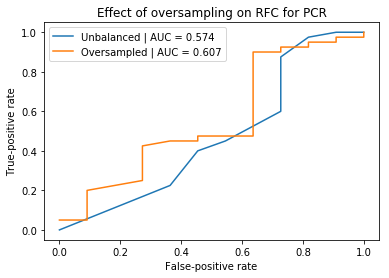

In [9]:
# standard
auc1, kappa1, fpr1, tpr1, _= RandomForest_Classifier(X, y)

# unbalanced learning
auc2, kappa2, fpr2, tpr2, _= RandomForest_Classifier(X, y, oversample=True, K_neighbors = 4)

title ='Effect of oversampling on RFC for PCR'
plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, title = title)

## 3.0 Survival (`Alive`) including PCR as predictor

In [12]:
# allocate new predictor variable
pcr = predictive_statistics.labels_to_numbers(df, 'PCR').reshape(168,1)
newX = np.concatenate((X,pcr), axis  = 1)

# standard
auc1, kappa1, fpr1, tpr1 = Logistic_Regression(newX, y)

# unbalanced learning
auc2, kappa2, fpr2, tpr2 = Logistic_Regression(newX, y, oversample=True, K_neighbors = 10)

             precision    recall  f1-score   support

          0       0.50      0.27      0.35        11
          1       0.82      0.93      0.87        40

avg / total       0.75      0.78      0.76        51

The estimated Cohen kappa is 0.236734693878
The estimated AUC is 0.599



Data was oversampled using the SMOTE method
             precision    recall  f1-score   support

          0       0.33      0.45      0.38        11
          1       0.83      0.75      0.79        40

avg / total       0.73      0.69      0.70        51

The estimated Cohen kappa is 0.180722891566
The estimated AUC is 0.602





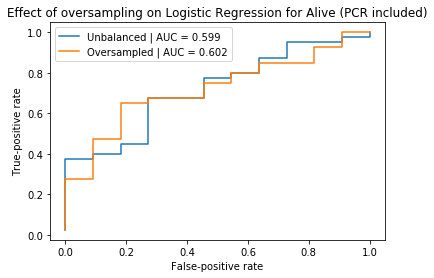

In [13]:
title ='Effect of oversampling on Logistic Regression for Alive (PCR included)'
plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, title = title)

## 4.0 Survival (`Alive`) including `RCB` as predictor

             precision    recall  f1-score   support

          0       0.57      0.36      0.44        11
          1       0.84      0.93      0.88        40

avg / total       0.78      0.80      0.79        51

The estimated Cohen kappa is 0.332460732984
The estimated AUC is 0.644



Data was oversampled using the SMOTE method
             precision    recall  f1-score   support

          0       0.37      0.64      0.47        11
          1       0.88      0.70      0.78        40

avg / total       0.77      0.69      0.71        51

The estimated Cohen kappa is 0.26618705036
The estimated AUC is 0.668





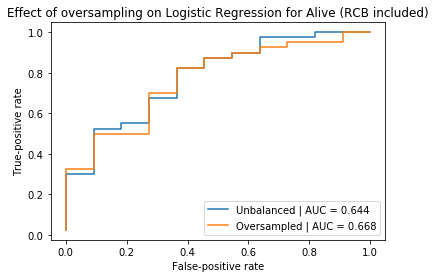

In [15]:
rcb = pd.get_dummies(df['RCB']).values
newX = np.concatenate((X,rcb), axis  = 1)

# standard
auc1, kappa1, fpr1, tpr1 = Logistic_Regression(newX, y)

# unbalanced learning
auc2, kappa2, fpr2, tpr2 = Logistic_Regression(newX, y, oversample=True, K_neighbors = 10)

title ='Effect of oversampling on Logistic Regression for Alive (RCB included)'
plot_compare_roc(fpr1, tpr1,fpr2, tpr2, auc1, auc2, title = title)

<h1><center> Prediction of continous outcomes</center></h1>

## Prepare functions

In [ ]:
# metrics
mae = metrics.median_absolute_error

def mae_report(Ytest, Yhat, outcome_):
    error = mae(Ytest, Yhat)
    error = np.round( error, decimals=3)
    # report
    print('\n' )
    print('==' *40)
    print('The median absolute error for testing data set of ' + outcome_ + ' is: ' + str(error))
    print('==' *40)

def train_test_report(predictor, Xtrain, Ytrain, Xtest, Ytest, outcome):
    # train
    predictor.fit(Xtrain, Ytrain)
    # test
    Yhat = predictor.predict(Xtest)
    # report
    mae_report(Ytest, Yhat, outcome)
    
# lsq 
import statsmodels.api as sm
def lsq(Xtrain,Ytrain, Xtest, Ytest, outcome =''):
    # train
    OLS = sm.OLS(Ytrain,Xtrain).fit();
    print(OLS.summary())
    #test
    Yhat = OLS.predict(Xtest)
    # report
    mae_report(Ytest, Yhat, outcome)

# SVR    
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV   

# GridSearchCV utility
def gridsearch(regressor, grid):
    optimized_regressor=  GridSearchCV(  regressor, 
                               param_grid = grid, 
                               cv= 3, verbose = 0, n_jobs = -1,
                               scoring = metrics.make_scorer(metrics.median_absolute_error))
    
    return optimized_regressor
    


def svr(Xtrain,Ytrain, Xtest, Ytest, outcome = ''):
    # define regressor
    regressor =  SVR()
    # define parameter grid search
    grid = dict(       kernel = ['rbf','linear','sigmoid'], 
                       C = np.arange(1,11,1),
                       epsilon = np.arange(1,11,1),
                       gamma = np.linspace(1/10,10,3))
    # perform grid search
    grid_search=  gridsearch(regressor, grid)
    
    # train, test, and report
    train_test_report(grid_search, Xtrain, Ytrain, Xtest, Ytest, outcome)

    
# ElasticNet
from sklearn.linear_model import ElasticNet as ENet

def ElasticNet(Xtrain,Ytrain, Xtest, Ytest, outcome = ''):
    # define regressor
    regressor =  ENet(max_iter=5000)
    # define parameter grid search
    grid = dict(   alpha = np.arange(1,20,.5), l1_ratio = np.arange(.1,1,.05))
    # perform grid search
    grid_search=  gridsearch(regressor, grid)
    # train, test, and report
    train_test_report(grid_search, Xtrain, Ytrain, Xtest, Ytest, outcome)
    

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor as RFR

def RandomForestRegressor(Xtrain,Ytrain, Xtest, Ytest, outcome = ''):
    # define regressor
    regressor =  RFR( criterion='mse', random_state = RANDOM_STATE)
    
    #
    num_features = Xtrain.shape[1]
    
    # define parameter grid search
    grid = dict(    n_estimators = np.arange(5,100,5), 
                    max_features = np.arange(1,num_features, 1),
                    max_depth = [None, 1, 2, 3, 4, 5])
    
    # perform grid search
    grid_search=  gridsearch(regressor, grid)
    
    # train, test, and report
    train_test_report(grid_search, Xtrain, Ytrain, Xtest, Ytest, outcome)
    

## Organize predictors in the right format and split data

In [ ]:
# allocate continous predictors
cont_predictors = ['age','MRI_LD_Baseline', 'MRI_LD_1_3dAC', 'MRI_LD_Int_Reg', 'MRI_LD_PreSurg']
contX = df[cont_predictors].values

# allocate categorical predictors
cat_pred = ['PCR','White', 'ER+', 'PR+', 'HR+'];
catX = pd.pandas.get_dummies(df[cat_pred], drop_first=True).values

# concatenate predictors
X = np.concatenate( (catX, contX), axis=1)

#outcome
y = df.RFS.values / 30; # conver to months

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

## 1.0 Recurrence-Free Survival (`RFS`, Continous in months)

In [ ]:
# LSQ
lsq(X_train, y_train, X_test, y_test, outcome =' Recurrence-Free Survival (months)')

### Categorical Predictors only Linear Regression

## ElasticNet

In [ ]:
ElasticNet(X_train, y_train, X_test, y_test, outcome =' Recurrence-Free Survival (months)')

## SVM Regressor

In [ ]:
svr(X_train, y_train, X_test, y_test, outcome =' Recurrence-Free Survival (months)')

## Random Fores regressor

In [ ]:
RandomForestRegressor(X_train, y_train, X_test, y_test, outcome =' Recurrence-Free Survival (months)')

## 2.0  Survival Length (`Survival_length`, Continous, months)

In [ ]:
y = df.Survival_length.values / 30
#split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

In [ ]:
# # LSQ
lsq(X_train, y_train, X_test, y_test, outcome ='Survival_length (months)')

In [ ]:
svr(X_train, y_train, X_test, y_test, outcome ='Survival length (months)')

In [ ]:
ElasticNet(X_train, y_train, X_test, y_test, outcome = 'Survival length (months)')